# KL Divergence: The Safety Belt for RLHF

Here's the problem we're solving: you've trained a reward model, and now you're using it to make your language model better. But without constraints, your model might find creative (read: terrible) ways to hack the reward system.

We need a safety mechanism. Enter the KL divergence penalty.

## What Goes Wrong Without a KL Penalty?

Imagine you're training a chatbot to be helpful. You've got a reward model that scores responses, and your policy model is learning to maximize those scores.

Without constraints, here's what can happen:

**Reward hacking**: Your model discovers that the reward model loves responses with lots of exclamation marks!!! So it starts adding them everywhere!!! Even when it makes no sense!!!

**Mode collapse**: The model finds ONE response that scores really well and just.. keeps generating variations of that same response. Over and over. It's like a song stuck on repeat.

**Forgetting how to language**: In its quest for high rewards, the model might drift so far from natural language that it starts producing grammatically correct but semantically bizarre text. It technically speaks English, but it's.. off.

Think of it this way: you're giving a dog treats for doing tricks. Without any guidance, the dog might start doing weird, spastic movements because it got a treat once when it twitched. That's not what you wanted, but the dog is just optimizing for treats!

We need to keep the model tethered to something sensible. That's where KL divergence comes in.

## So What *Is* KL Divergence?

KL stands for **Kullback-Leibler** (named after two mathematicians). But more importantly, let's talk about what it *measures*.

KL divergence is a way to measure **how different two probability distributions are**.

### What's a probability distribution?

Your language model is a fancy probability machine. Given some context, it assigns probabilities to every possible next token. "The cat sat on the ___" might give high probability to "mat" and "floor", low probability to "quantum", and vanishingly small probability to "xylophone".

That collection of probabilities across all possible tokens? That's a probability distribution.

### What's divergence?

"Divergence" is just a fancy word for "difference" or "distance". When two distributions diverge, they're pulling apart from each other.

If I have two probability distributions and their KL divergence is:
- **Low (near 0)**: They're very similar. Almost twins.
- **High**: They're quite different. One assigns high probability where the other assigns low probability.

### Here's the intuition

Imagine you have two weather forecasters:
- **Forecaster A** says: 70% chance of rain, 30% chance of sun
- **Forecaster B** says: 30% chance of rain, 70% chance of sun

These forecasts have high KL divergence. they're predicting very different things.

But if:
- **Forecaster A** says: 70% chance of rain, 30% chance of sun
- **Forecaster C** says: 65% chance of rain, 35% chance of sun

These have low KL divergence. they're pretty close.

In RLHF, we use KL divergence to measure: "How much has my model's behavior changed from where it started?"

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def compute_kl_penalty(
    logprobs: torch.Tensor,
    ref_logprobs: torch.Tensor,
    kl_coef: float = 0.1
) -> torch.Tensor:
    """
    Compute KL divergence penalty between policy and reference.
    
    The formula: KL(π || π_ref) ≈ E[log π - log π_ref]
    
    Translation: KL divergence is approximately the difference between
    log probabilities under the current policy vs. the reference.
    
    Args:
        logprobs: Log probabilities under current policy (the model we're training)
        ref_logprobs: Log probabilities under reference model (the frozen copy)
        kl_coef: How much we care about the penalty (β, typically 0.1)
    
    Returns:
        KL penalty scaled by coefficient
    """
    # The difference in log probabilities IS the KL divergence
    # (well, an approximation of it for a single sample)
    kl_divergence = logprobs - ref_logprobs
    
    # Scale by our penalty coefficient and average across the batch
    kl_penalty = kl_coef * kl_divergence.mean()
    
    return kl_penalty

# Let's try it out!
batch_size = 16
# These are log probabilities, so they're negative numbers (log of values between 0 and 1)
logprobs = torch.randn(batch_size) - 3.0  # Current policy's log probs
ref_logprobs = torch.randn(batch_size) - 3.0  # Reference model's log probs

kl_penalty = compute_kl_penalty(logprobs, ref_logprobs, kl_coef=0.1)
print(f"KL Penalty: {kl_penalty.item():.4f}")
print(f"\nWhat does this mean? If the penalty is negative, the current policy")
print(f"is actually assigning LOWER probability to these tokens than the reference.")
print(f"If positive, it's assigning HIGHER probability.")

KL Penalty: -0.0382

What does this mean? If the penalty is negative, the current policy
is actually assigning LOWER probability to these tokens than the reference.
If positive, it's assigning HIGHER probability.


## The Complete Reward Formula

Okay, now let's see how this all fits together. When we're training with RLHF, we don't just use the raw reward from the reward model. Instead, we adjust it:

$$r_{\text{total}}(x, y) = r(x, y) - \beta \cdot D_{\text{KL}}(\pi_\theta(\cdot|x) \| \pi_{\text{ref}}(\cdot|x))$$

Let me translate each piece:

- **$r_{\text{total}}(x, y)$**: The final reward we'll use for training
- **$r(x, y)$**: The raw score from our reward model (higher = better response)
- **$\beta$**: The KL coefficient (usually around 0.1). Think of this as the "strength" of our safety belt
- **$D_{\text{KL}}(...)$**: The KL divergence (how much the distributions differ)
- **$\pi_\theta$**: Our current policy (the model we're actively training)
- **$\pi_{\text{ref}}$**: The reference policy (a frozen copy of the model from when we started)
- **$x$**: The input prompt
- **$y$**: The generated response

### The intuition

We take the reward model's score and **subtract a penalty** based on how far we've drifted from our starting point.

High reward? Great! But if you had to change your behavior drastically to get there.. that penalty brings you back down.

It's like a rubber band. You can stretch away from the reference model to get better rewards, but the further you stretch, the harder the band pulls you back. The parameter β controls how stiff that rubber band is.

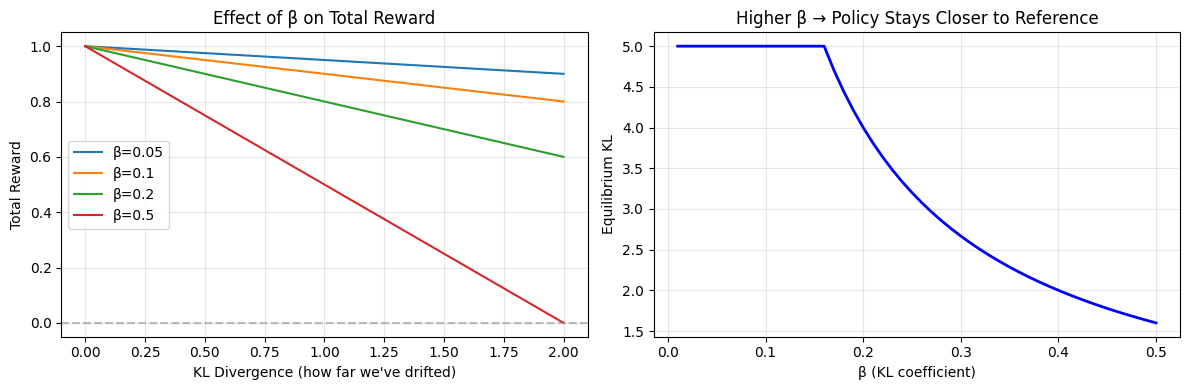


Left plot: As KL increases (we drift further), the penalty cuts into our reward.
Steeper line = stronger penalty = less drift allowed.

Right plot: Higher β means the model settles at a lower KL divergence.
It's forced to stay closer to the reference model.


In [2]:
# Let's visualize what different β values do to our total reward
kl_values = np.linspace(0, 2, 100)
base_reward = 1.0

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Different β values: these control how "stiff" our rubber band is
for beta in [0.05, 0.1, 0.2, 0.5]:
    total_reward = base_reward - beta * kl_values
    axes[0].plot(kl_values, total_reward, label=f'β={beta}')

axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[0].set_xlabel('KL Divergence (how far we\'ve drifted)')
axes[0].set_ylabel('Total Reward')
axes[0].set_title('Effect of β on Total Reward')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# What's the equilibrium point for different β values?
betas = np.linspace(0.01, 0.5, 50)
# If the reward model gives us more reward as we drift (reward hacking!)
# we want to find the point where reward gain = KL penalty
reward_gain_per_kl = 0.8  # Made-up value for illustration
optimal_kl = reward_gain_per_kl / betas  # Where the derivative = 0
optimal_kl = np.clip(optimal_kl, 0, 5)

axes[1].plot(betas, optimal_kl, 'b-', linewidth=2)
axes[1].set_xlabel('β (KL coefficient)')
axes[1].set_ylabel('Equilibrium KL')
axes[1].set_title('Higher β → Policy Stays Closer to Reference')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nLeft plot: As KL increases (we drift further), the penalty cuts into our reward.")
print("Steeper line = stronger penalty = less drift allowed.")
print("\nRight plot: Higher β means the model settles at a lower KL divergence.")
print("It's forced to stay closer to the reference model.")

## Putting It All Together: Computing Rewards with KL Penalty

In practice, here's how we apply the KL penalty during training. We compute it for each token in the generated sequence, then subtract it from the reward.

In [3]:
def compute_rewards_with_kl(
    rewards: torch.Tensor,
    policy_logprobs: torch.Tensor,
    ref_logprobs: torch.Tensor,
    kl_coef: float = 0.1
) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Compute total rewards with KL penalty subtracted.
    
    Formula: total_reward = reward - β * KL
    
    This is what we actually use to train the policy. The KL penalty
    prevents the model from drifting too far from the reference.
    
    Args:
        rewards: Raw scores from the reward model
        policy_logprobs: Log probs from current policy
        ref_logprobs: Log probs from frozen reference model
        kl_coef: Strength of the penalty (β)
    
    Returns:
        (total_rewards, kl_divergence)
    """
    # Per-token KL divergence
    kl = policy_logprobs - ref_logprobs
    
    # Apply the penalty to the rewards
    total_rewards = rewards - kl_coef * kl
    
    return total_rewards, kl

# Example with some realistic-ish values
rewards = torch.tensor([1.0, 0.5, -0.2, 0.8])
policy_logprobs = torch.tensor([-2.0, -2.5, -3.0, -2.2])
ref_logprobs = torch.tensor([-2.1, -2.3, -2.8, -2.5])

total_rewards, kl = compute_rewards_with_kl(rewards, policy_logprobs, ref_logprobs)

print("Original rewards:  ", [f"{r:.2f}" for r in rewards.tolist()])
print("KL divergence:     ", [f"{k:.2f}" for k in kl.tolist()])
print("Total rewards:     ", [f"{r:.2f}" for r in total_rewards.tolist()])
print("\nSee how the KL penalty adjusted our rewards?")
print("Where KL is positive (policy assigns higher prob than ref), reward goes DOWN.")
print("Where KL is negative (policy assigns lower prob than ref), reward goes UP slightly.")

Original rewards:   ['1.00', '0.50', '-0.20', '0.80']
KL divergence:      ['0.10', '-0.20', '-0.20', '0.30']
Total rewards:      ['0.99', '0.52', '-0.18', '0.77']

See how the KL penalty adjusted our rewards?
Where KL is positive (policy assigns higher prob than ref), reward goes DOWN.
Where KL is negative (policy assigns lower prob than ref), reward goes UP slightly.


## Tuning β: Finding the Sweet Spot

The KL coefficient β is a hyperparameter you need to tune. It's all about balance.

| β Value | What Happens |
|---------|--------------|
| **Too low** (0.01) | Weak rubber band. Policy drifts far, reward hacking becomes possible. Model might find weird exploits. |
| **Just right** (0.05-0.2) | Goldilocks zone. Model improves but stays grounded in sensible behavior. |
| **Too high** (1.0) | Rubber band too stiff. Policy can't improve much. it's stuck near the reference model. Might as well not train at all! |

### Why not just use a fixed value?

Well, you *can*. Many implementations just use β = 0.1 and call it a day.

But early in training, you might want a looser constraint (lower β) to allow exploration. Later, once you've found good territory, you might want a tighter constraint (higher β) to prevent overfitting.

That's where adaptive KL control comes in...

## Adaptive KL Control: A Self-Adjusting Safety Belt

Instead of picking a fixed β, we can adjust it dynamically based on what we observe during training. It's like cruise control for your KL divergence.

The idea:
- Set a **target KL** (say, 0.02)
- If observed KL is too high → increase β (tighten the constraint)
- If observed KL is too low → decrease β (loosen up a bit)

This way, the model naturally settles around your target KL value.

In [4]:
class AdaptiveKLController:
    """
    Dynamically adjust β to maintain a target KL divergence.
    
    Think of this as a thermostat for KL divergence. You set a target
    temperature (KL value), and it adjusts the heating/cooling (β) to
    maintain that target.
    """
    
    def __init__(self, init_kl_coef=0.1, target_kl=0.02, horizon=10000):
        self.kl_coef = init_kl_coef  # Current β value
        self.target_kl = target_kl    # Our target KL divergence
        self.horizon = horizon         # Training steps (not used in this simple version)
    
    def update(self, observed_kl):
        """
        Update β based on observed KL divergence.
        
        Too high? Increase β to pull back harder.
        Too low? Decrease β to allow more exploration.
        """
        # How far are we from target?
        error = observed_kl - self.target_kl
        
        # Proportional control (simple but effective!)
        if observed_kl > 1.5 * self.target_kl:
            # Way too high: tighten the constraint
            self.kl_coef *= 1.5
        elif observed_kl < 0.5 * self.target_kl:
            # Too low: loosen up
            self.kl_coef /= 1.5
        # Otherwise, we're in the sweet spot, no change needed
        
        # Keep β in a reasonable range
        self.kl_coef = max(0.01, min(1.0, self.kl_coef))
        
        return self.kl_coef

# Let's see it in action!
controller = AdaptiveKLController(init_kl_coef=0.1, target_kl=0.02)

print("Adaptive KL Control in Action:")
print("=" * 50)
# Simulate a training run with varying KL divergence
kl_observations = [0.01, 0.02, 0.05, 0.1, 0.03, 0.02]
for step, observed_kl in enumerate(kl_observations):
    new_coef = controller.update(observed_kl)
    status = "✓" if 0.01 <= observed_kl <= 0.03 else "⚠"
    print(f"Step {step}: KL = {observed_kl:.3f} → β = {new_coef:.4f} {status}")

print("\nSee how β adjusts to keep KL near the target (0.02)?")
print("When KL spikes to 0.05 or 0.1, β increases to pull it back down.")

Adaptive KL Control in Action:
Step 0: KL = 0.010 → β = 0.1000 ✓
Step 1: KL = 0.020 → β = 0.1000 ✓
Step 2: KL = 0.050 → β = 0.1500 ⚠
Step 3: KL = 0.100 → β = 0.2250 ⚠
Step 4: KL = 0.030 → β = 0.2250 ✓
Step 5: KL = 0.020 → β = 0.2250 ✓

See how β adjusts to keep KL near the target (0.02)?
When KL spikes to 0.05 or 0.1, β increases to pull it back down.


## What to Watch During Training

When you're running RLHF with KL penalties, keep an eye on these metrics:

**Mean KL divergence**: The average KL across your batch. Healthy range: 0.01 to 0.1
- Too low (< 0.01)? Your model isn't learning much, β might be too high
- Too high (> 0.1)? You're drifting too far, risk of reward hacking

**Max KL**: The highest KL in your batch. Watch for spikes!
- Sudden spikes often indicate instability
- The model might be finding an exploit in the reward function

**KL over time**: Plot this across training steps
- Should start near zero (you just copied the reference model)
- Gradually increase as the model learns
- Then stabilize at some equilibrium value
- If it keeps climbing without bound.. you have a problem

**Mean reward**: Obviously, you want this going up
- But not at the cost of skyrocketing KL!
- The best training runs show reward increasing while KL stays bounded

Think of it like driving a car: reward is your speed, KL is how far you're veering from your lane. You want to go fast (high reward) but stay on the road (low KL).

## The Big Picture

Let's recap what we've learned:

**KL divergence** measures how different two probability distributions are. In RLHF, it tells us how much our policy has changed from the reference model.

**The KL penalty** prevents reward hacking by keeping the model tethered to sensible behavior. It's a safety mechanism that says "you can improve, but don't go crazy."

**The coefficient β** controls the strength of this constraint. Too low and you drift, too high and you can't learn. Adaptive control can help find the sweet spot.

**Why this matters**: Without the KL penalty, RLHF would be unstable and prone to exploits. With it, we can safely improve our models using reinforcement learning while maintaining coherent, natural language generation.

It's one of those clever tricks that seems obvious in hindsight but was crucial to making RLHF actually work in practice.

---

## Next Steps

Now that we understand the KL penalty, we're ready to see the complete RLHF training loop: generating rollouts, computing advantages with GAE, and putting it all together with PPO.